In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [3]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','long_int','short_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'] / df_variable_raw['CPI'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])
variable_list = ['GDP', 'inf_rate','long_int','short_int','exch_rate']
ext_variable_list = ['Real gross domestic product','Inflation rate','Long-term interest rate','Short-term interest rate','Real exchange rate']

In [4]:
# Example of the data of GDP
df_variable['GDP']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,,,,,,,,,,,,,,,,,,,,,
Australia,7.111526,7.109974,7.109045,7.108639,7.108802,7.109724,7.111451,7.113886,7.117012,7.120009,...,7.245003,7.242691,7.240865,7.237977,7.234116,7.229641,7.224830,7.220180,7.215890,7.212375
Brazil,7.298547,7.265720,7.255515,7.248464,7.248838,7.252285,7.254880,7.258204,7.255993,7.247954,...,6.245628,6.238087,6.235718,6.230620,6.238351,6.242242,6.244860,6.238253,6.232938,6.225192
Canada,7.182050,7.181960,7.179124,7.179272,7.178639,7.181598,7.184533,7.187242,7.188597,7.188877,...,7.249739,7.246856,7.236032,7.232001,7.232621,7.237186,7.237162,7.230052,7.228093,7.232778
France,7.380348,7.374446,7.367507,7.366746,7.365897,7.368816,7.372472,7.375927,7.374124,7.372342,...,7.389731,7.387556,7.382731,7.376268,7.373598,7.368834,7.374215,7.363898,7.361342,7.363840
Germany,7.682714,7.688150,7.695440,7.699543,7.700288,7.699928,7.699483,7.701185,7.704330,7.707481,...,7.624106,7.616684,7.606889,7.607831,7.605180,7.603438,7.586272,7.577714,7.571316,7.566637
Italy,7.396040,7.389030,7.383779,7.379578,7.376119,7.374964,7.376462,7.375475,7.373617,7.371353,...,7.043788,7.048628,7.044076,7.034828,7.031480,7.023761,7.020841,6.986684,6.981243,6.978765
Japan,12.850322,12.864937,12.870368,12.868049,12.867329,12.870474,12.871490,12.873739,12.872666,12.874797,...,12.959260,12.960084,12.961055,12.962100,12.956011,12.949845,12.943860,12.937610,12.938058,12.942606
Korea,13.774596,13.780142,13.781106,13.780902,13.780954,13.786446,13.787371,13.788933,13.793843,13.800024,...,14.099692,14.094856,14.090692,14.086429,14.082658,14.084086,14.080734,14.076859,14.075656,14.070829
New Zealand,5.010273,5.009471,5.010367,5.012259,5.014867,5.017504,5.019902,5.021249,5.021431,5.020249,...,5.200104,5.201987,5.205242,5.206727,5.206079,5.203146,5.198064,5.190857,5.181424,5.169673


In [5]:
# Get all countries in a list
country_list = df_variable['GDP'].index.values

# Define an empty dataframe
df = {}

# Loop over all countries and put their variable data in dataframe df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [6]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,9.442539,9.449189,9.451437,9.452844,9.454810,9.457333,9.458181,9.459295,9.459754,9.460273,...,9.439093,9.433012,9.422873,9.411266,9.414238,9.417735,9.418474,9.416719,9.418875,9.421459
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.260000,-4.263243,-4.268298,-4.272212,-4.274163,-4.274720,-4.276666,-4.278609,-4.281792,-4.284965,...,-4.881665,-4.887262,-4.898213,-4.911846,-4.911699,-4.911330,-4.913537,-4.917569,-4.916544,-4.913463


# Trade matrix

In [7]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1994 until 2022)
year_list = df_trade_raw.columns

# Define an empty dataframe
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dataframe df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [8]:
# Example of the trade weights on the year 2000
df_trade_year[2000]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.009499,0.024256,0.015715,0.022248,0.031067,0.368421,0.139010,0.109102,0.021377,0.012284,0.063816,0.183204
Brazil,0.012822,0.000000,0.021274,0.065131,0.095000,0.080711,0.092992,0.021844,0.001296,0.011364,0.037926,0.056359,0.503281
Canada,0.003000,0.002689,0.000000,0.004871,0.007887,0.004335,0.022968,0.005707,0.000482,0.000620,0.001581,0.014831,0.931028
France,0.006890,0.014365,0.014387,0.000000,0.277243,0.155041,0.027482,0.013763,0.001199,0.006146,0.160982,0.169509,0.152993
Germany,0.011850,0.017602,0.015107,0.236602,0.000000,0.158056,0.046231,0.015814,0.001668,0.013074,0.093985,0.173398,0.216612
Italy,0.013134,0.016574,0.015812,0.224279,0.267343,0.000000,0.029327,0.012335,0.001646,0.006712,0.111315,0.121739,0.179782
Japan,0.034618,0.010164,0.030154,0.030228,0.080685,0.023379,0.000000,0.123875,0.005102,0.007577,0.013335,0.059860,0.581023
Korea,0.031966,0.021146,0.029763,0.021458,0.063209,0.023418,0.251006,0.000000,0.003509,0.006069,0.018803,0.065981,0.463673
New Zealand,0.302224,0.003885,0.022302,0.022475,0.034591,0.025347,0.205571,0.065756,0.000000,0.005530,0.008444,0.082456,0.221417
South Africa,0.042235,0.017777,0.019369,0.047268,0.167820,0.074288,0.119648,0.052628,0.002717,0.000000,0.043997,0.199527,0.212726


In [9]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[1993] + df_trade_year[1994] + df_trade_year[1995])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.008695,0.031125,0.020313,0.027501,0.029473,0.422486,0.132150,0.115496,0.012373,0.007620,0.067694,0.125073
Brazil,0.012786,0.000000,0.024467,0.046825,0.103713,0.080085,0.136933,0.034136,0.001838,0.011543,0.039634,0.063569,0.444472
Canada,0.004381,0.004788,0.000000,0.006822,0.012462,0.006200,0.048321,0.010508,0.000680,0.000768,0.001999,0.015696,0.887375
France,0.007999,0.007755,0.012718,0.000000,0.317674,0.173072,0.035865,0.012381,0.001229,0.006044,0.129186,0.174254,0.121825
Germany,0.015579,0.018173,0.013884,0.262833,0.000000,0.165993,0.058338,0.024076,0.002175,0.016558,0.073423,0.176180,0.172786
Italy,0.011154,0.017354,0.015598,0.230207,0.336073,0.000000,0.037012,0.015691,0.001984,0.007676,0.082110,0.112037,0.133103
Japan,0.040304,0.009912,0.029764,0.027565,0.092120,0.017409,0.000000,0.121341,0.007258,0.010393,0.010995,0.063685,0.569254
Korea,0.027392,0.018277,0.031319,0.023447,0.093984,0.016194,0.287797,0.000000,0.003286,0.007146,0.013616,0.042586,0.434957
New Zealand,0.313003,0.005407,0.025821,0.017027,0.037556,0.020387,0.237031,0.075653,0.000000,0.003830,0.006465,0.091912,0.165908
South Africa,0.029227,0.024074,0.012801,0.063221,0.153470,0.093988,0.105488,0.054068,0.002478,0.000000,0.046956,0.234887,0.179344


# VARX model

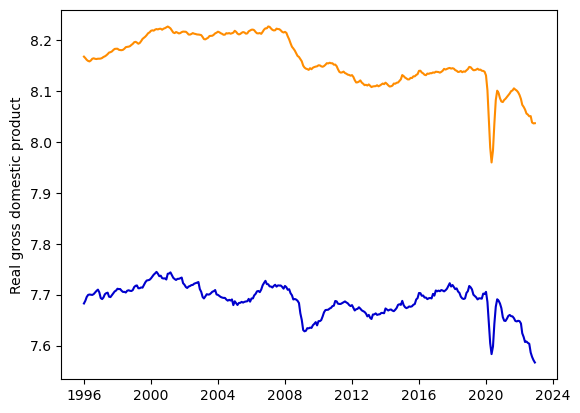

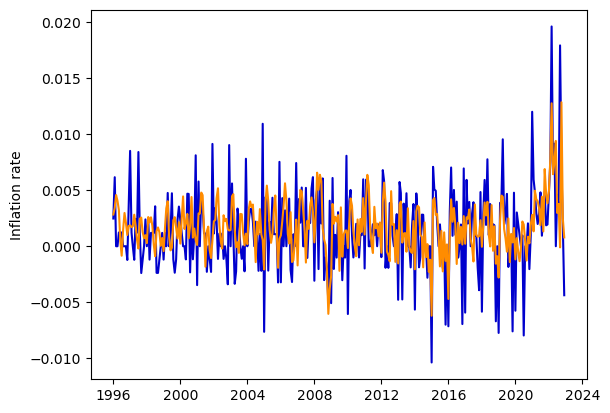

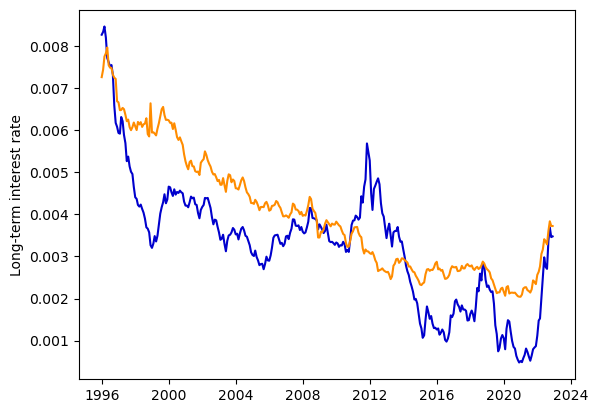

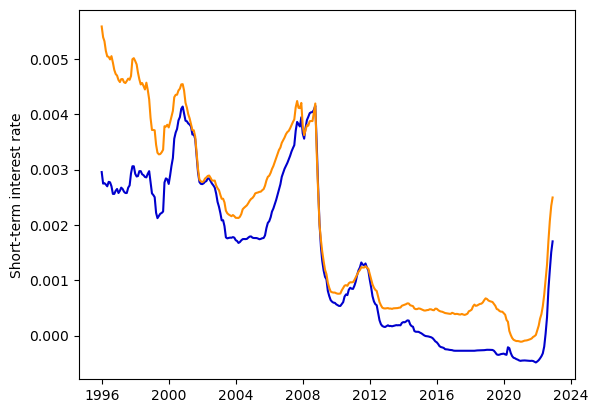

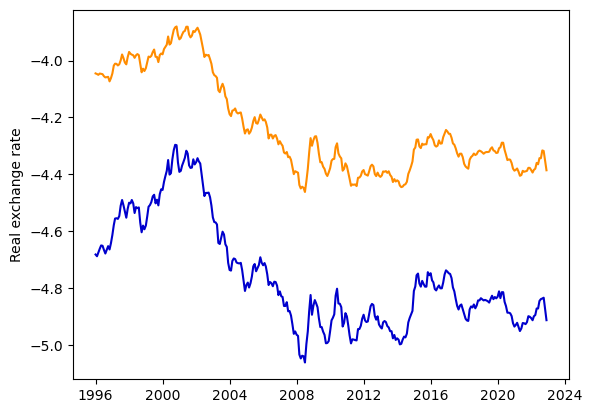

In [10]:
# Define the country
country = 'Germany'

# Define the x_it and x_star for a country
x_it = df[country].T
x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)

# Plot x_it and x_star for every variable
for i in range(len(variable_list)):
    sns.lineplot(x_it[variable_list[i]],c='mediumblue')
    sns.lineplot(x_star[variable_list[i]],c='darkorange')
    plt.ylabel(ext_variable_list[i])
    plt.show()

In [11]:
# Define a dataframe (dictionary) for the parameter estimates and the R_squared
df_estimates = {}
df_Rsquared = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    # Define matrix x_it
    x_it = df[country].T
    x_it.columns = x_it.columns + "_x_it"
    
    # Define matrix x_star
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.columns = x_star.columns + "_x_star"

    # Combine x_it and x_star and define the period frequency
    df_country = pd.concat([x_it,x_star], axis=1)
    df_country.index.freq = 'MS'

    # Create a VAR model object
    model = VAR(df_country)

    # Fit the VAR model with a constant and trend
    results = model.fit(maxlags=2,trend='ct')

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [12]:
# Example of the VARX estimates of Australia
df_estimates['France']

,const,trend,L1.GDP_x_it,L1.inf_rate_x_it,L1.long_int_x_it,L1.short_int_x_it,L1.exch_rate_x_it,L1.GDP_x_star,L1.inf_rate_x_star,L1.long_int_x_star,...,L2.GDP_x_it,L2.inf_rate_x_it,L2.long_int_x_it,L2.short_int_x_it,L2.exch_rate_x_it,L2.GDP_x_star,L2.inf_rate_x_star,L2.long_int_x_star,L2.short_int_x_star,L2.exch_rate_x_star
GDP_x_it,0.406924,-1.866708e-05,2.524100,2.137614,-0.735214,9.881797,0.043801,-1.040454,-1.661415,-0.568126,...,-1.678745,0.144611,-0.341219,-7.287179,-0.001357,1.131733,0.021311,0.784406,3.845258,0.029538
inf_rate_x_it,-0.117453,1.158721e-05,0.109146,-0.234940,3.269674,-0.314627,0.051330,-0.144332,0.349201,-0.287443,...,-0.088165,-0.189294,-2.491632,-0.172865,-0.059884,0.140412,0.203626,0.212832,0.808871,0.062461
long_int_x_it,0.000859,-8.266911e-07,0.000958,0.005266,1.212131,-0.110724,0.001243,-0.001851,0.005432,-0.029614,...,0.000240,0.006977,-0.259973,0.105310,-0.001300,0.000670,-0.005085,0.027392,-0.114552,0.001565
short_int_x_it,-0.003800,2.627400e-07,-0.000753,-0.000993,0.015721,1.316832,0.001937,0.001546,0.003329,0.021866,...,0.000062,0.000249,0.036389,-0.409562,-0.000505,-0.000554,0.002531,-0.023995,-0.106382,0.001046
exch_rate_x_it,-0.041742,-2.016550e-04,0.120221,0.501323,-15.004869,-47.487709,1.201630,-0.297481,-0.255456,-10.402733,...,0.055578,0.026403,2.617079,49.927285,-0.241522,0.125008,0.533008,14.738968,-68.967911,-0.032028


In [13]:
# Example of the VARX estimates of New Zealand
df_estimates['New Zealand']

,const,trend,L1.GDP_x_it,L1.inf_rate_x_it,L1.long_int_x_it,L1.short_int_x_it,L1.exch_rate_x_it,L1.GDP_x_star,L1.inf_rate_x_star,L1.long_int_x_star,...,L2.GDP_x_it,L2.inf_rate_x_it,L2.long_int_x_it,L2.short_int_x_it,L2.exch_rate_x_it,L2.GDP_x_star,L2.inf_rate_x_star,L2.long_int_x_star,L2.short_int_x_star,L2.exch_rate_x_star
GDP_x_it,0.626500,-1.207283e-05,1.952482,-0.086692,0.332401,0.061431,-0.027678,-0.511559,-0.118630,-0.665586,...,-0.994808,0.406224,-1.381269,-0.193955,0.024408,0.471133,-0.322313,-1.680265,-4.647583,0.011733
inf_rate_x_it,0.004384,3.857015e-06,-0.049524,1.304638,0.379744,1.027875,0.005447,0.072044,0.183061,0.106535,...,0.053039,-0.812000,-0.490896,-0.685533,-0.001700,-0.074790,0.018321,0.228295,0.433713,-0.000576
long_int_x_it,-0.001141,-4.558094e-07,-0.002761,0.009983,1.103850,0.041870,0.000764,0.001120,0.007735,0.087609,...,0.001976,-0.009357,-0.171308,-0.058903,-0.000478,-0.000600,0.008212,-0.085723,0.010875,0.000845
short_int_x_it,-0.003976,-9.874952e-07,0.000258,0.004480,0.062316,1.453801,-0.000620,-0.000872,0.003480,0.074367,...,0.000571,-0.001659,-0.026686,-0.507755,0.000263,0.000866,0.007544,-0.102212,-0.221609,0.000603
exch_rate_x_it,-0.820733,-2.863119e-05,0.357103,-1.694418,17.425127,-7.323028,1.013903,-0.579023,0.056229,-13.932655,...,-0.404905,0.166669,-23.900321,6.345913,-0.057306,0.676490,1.884796,20.134704,22.224415,-0.472604


In [14]:
# The matrix of R^2 values
df_Rsquared

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,0.996420,0.999823,0.983727,0.978516,0.975789,0.998927,0.993441,0.998754,0.996100,0.999277,0.990944,0.991077,0.985965
inf_rate,0.900378,0.482354,0.237066,0.153338,0.106525,0.311771,0.267246,0.322291,0.903067,0.381685,0.265264,0.300832,0.419196
long_int,0.989153,0.990304,0.993433,0.994413,0.985498,0.982796,0.987872,0.989336,0.989934,0.991537,0.983807,0.964443,0.982094
short_int,0.995529,0.957121,0.993434,0.996983,0.996938,0.997582,0.989441,0.991027,0.995684,0.988694,0.997408,0.996697,0.992848
exch_rate,0.993686,0.985555,0.994810,0.987615,0.987536,0.989952,0.965695,0.984525,0.993207,0.961612,0.991658,0.978264,0.999729
